#Importing Libraries


In [1]:
!pip install pyLDAvis


     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8d614896a827069741780cc9615f4db51919acf73546188cf55400e821538e79
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
nltk.download('stopwords')

import gensim
from gensim.corpora import Dictionary

from IPython.display import clear_output

import pyLDAvis.gensim_models as gensim_models
from gensim.models.coherencemodel import CoherenceModel


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Preparing data and storing in df dataframe


In [3]:
df = pd.read_csv('/content/ahram_political_reviews.csv').drop('Unnamed: 0', axis =1)
df.head()

,political_review,date
0,Parliament approves law setting up Egyptian He...,2022-02-09
1,New head of Egypt's Supreme Constitutional Cou...,2022-02-09
2,Egypt’s HR council hails as 'historic step' th...,2022-02-09
3,Sisi names first Christian as president of Egy...,2022-02-08
4,Egyptian parliament rejects draft law imposing...,2022-02-08


#Finding Null values


In [4]:
df.isnull().sum()


political_review    0
date                0
dtype: int64

In [5]:
df[df.duplicated() == True]


,political_review,date


In [6]:
stop_words = stopwords.words("english")


#Functions to clean Text via REGEX


In [7]:
import re
"""Functions to clean text using Regex"""
ip_addr_regex = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def regex_cleaning(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^a-zA-Z0-9]+", " ", phrase)
    phrase = re.sub(r"\r\n", "", phrase)            # Removing additional line
    phrase = re.sub(r"\n", "", phrase)              # Removing additional line 
    phrase = re.sub(r"\S*@\S*\s?", "", phrase)      # Removing email-addresses 
    phrase = re.sub(r'http\S+', '', phrase)         # Removing website links
    phrase = re.sub(ip_addr_regex, "", phrase)      # Removing IP address link.
    phrase = emoji_pattern.sub(r'', phrase)         # Removing Emojis
    
    return phrase.lower() 

df['cleaned_text'] = df['political_review'].apply(regex_cleaning)

In [8]:
df.head()


,political_review,date,cleaned_text
0,Parliament approves law setting up Egyptian He...,2022-02-09,parliament approves law setting up egyptian he...
1,New head of Egypt's Supreme Constitutional Cou...,2022-02-09,new head of egypt is supreme constitutional co...
2,Egypt’s HR council hails as 'historic step' th...,2022-02-09,egypt s hr council hails as historic step the ...
3,Sisi names first Christian as president of Egy...,2022-02-08,sisi names first christian as president of egy...
4,Egyptian parliament rejects draft law imposing...,2022-02-08,egyptian parliament rejects draft law imposing...


#Using Lemmatization to clean words for analysis


In [9]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm") #loading english words to nlp 
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)
df['cleaned_text1'] = lemmatization(df.cleaned_text)

In [10]:
print (df['cleaned_text1'][0][0:70])

approve law set


#Tokenization of words using Gensim's Simple Preprocess tool


In [11]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

df['cleaned_text2'] = gen_words(df['cleaned_text1'])

print (df['cleaned_text2'][0][0:40])

['approve', 'law', 'set']


#Bigrams and Trigrams

In [12]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['cleaned_text2'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['cleaned_text2']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(df['cleaned_text2'])
df['cleaned_text2'] = make_trigrams(data_bigrams)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [13]:
print (df['cleaned_text2'])


0                                     [approve, law, set]
1          [new, head, constitutional_court, swear, sisi]
2       [hail, historic, step, appointment, eskandar, ...
3               [sisi, name, first, constitutional_court]
4       [egyptian, reject, draft, law, impose, fine, p...
                              ...                        
9995                  [sisi, arrive, ahead, arab, summit]
9996    [concern, military, escalation, call, end, hum...
9997    [say, kill, suspect, arrest, part, operation_s...
9998                                [receive, portuguese]
9999                [condemn, torching, israeli, settler]
Name: cleaned_text2, Length: 10000, dtype: object


#Using Vader for Sentiment Analysis on lemmatized words


In [14]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [15]:
df['LabelFromVADER'] = df['cleaned_text1'].apply(lambda review: "pos" if sentimentAnalyser.polarity_scores(review)['compound'] > 0.5 else "neg")


In [16]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['cleaned_text2']) #converting trigram bigram cleaned data into corpora dictionary with tokens assigned unique id 

texts = df['cleaned_text2'].copy()

corpus = [id2word.doc2bow(text) for text in texts] #collecting id2word in form of Bag Of Words (bow)
print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word) #starting tf-idf model

low_value = 0.03 #lowest threshold, if the word appears with this frequency, it is using a lot of space and maybe also delimitting words which are important to corpus 
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value] 
    drops = low_value_words+words_missing_in_tfidf #drops words which are so frequent, present everywhere 
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[(0, 1), (1, 1), (2, 1)]


In [24]:
#LDA MODEL generation/declaration
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #running till 2nd last object in list 
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
# train model, this might takes time
model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #running till 2nd last object in list 
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
# save model to disk (no need to use pickle module)
model.save('lda.model')

In [18]:
#testing on document till 2nd last word
test_doc = corpus[-1]
vector = lda_model[test_doc] #converting to vector
print(vector) # stores output in different opics, degree to relevance to that topic 

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)

[(0, 0.09183687), (1, 0.08251491), (2, 0.07826659), (3, 0.08120294), (4, 0.05738639), (5, 0.21644911), (6, 0.097879946), (7, 0.06931297), (8, 0.15682885), (9, 0.068321414)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.069

In [26]:
lda_model.save("/content/lda.model.state") #saving MODEL for further use

In [27]:
new_model = gensim.models.ldamodel.LdaModel.load("/content/lda.model.state") #new model for this exercise


In [28]:
test_doc = corpus[-1]
vector = new_model[test_doc] #converting to vector
print(vector) # stores output in different opics, degree to relevance to that topic 

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)

[(0, 0.09183687), (1, 0.08251491), (2, 0.07826659), (3, 0.08120294), (4, 0.05738639), (5, 0.21644911), (6, 0.097879946), (7, 0.06931297), (8, 0.15682885), (9, 0.068321414)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.06931297), (9, 0.068321414), (4, 0.05738639)]

[(5, 0.21644911), (8, 0.15682885), (6, 0.097879946), (0, 0.09183687), (1, 0.08251491), (3, 0.08120294), (2, 0.07826659), (7, 0.069

#Visualization of the textual data


In [29]:
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(new_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.346759  0.219849       1        1  12.626541
0      0.108967  0.384704       2        1  11.702353
8     -0.310517 -0.255281       3        1  10.519331
1     -0.209111  0.358476       4        1  10.484178
3      0.154740 -0.405895       5        1  10.229074
2     -0.163702  0.139482       6        1   9.713202
5     -0.071256 -0.289396       7        1   9.571978
7     -0.397021  0.011819       8        1   8.836112
9      0.161611 -0.070605       9        1   8.705222
4      0.379529 -0.093152      10        1   7.612009, topic_info=          Term         Freq        Total Category  logprob  loglift
6         sisi  1542.000000  1542.000000  Default  30.0000  30.0000
17    egyptian  1046.000000  1046.000000  Default  29.0000  29.0000
5          new   526.000000   526.000000  Default  28.0000  28.0000
23     discuss   646.000000   646.000000  Default  27.0000  27.0000
131        say   421.000000   421.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
797   cultural    21.610292    22.431070  Topic10  -5.2265   2.5382
337    traffic    21.453559    22.273936  Topic10  -5.2338   2.5379
2220    center    20.104103    20.929525  Topic10  -5.2987   2.5352
1558   justice    18.659581    19.483926  Topic10  -5.3733   2.5322
1747    lawyer    25.603083    27.843481  Topic10  -5.0569   2.4916

[331 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
1702     10  0.982267              additional
981      10  0.950357  administrative_capital
327       5  0.987479                 african
397       4  0.989350               agreement
324       6  0.992989                   ahead
...     ...       ...                     ...
2027      8  0.978713                    wind
1297      4  0.989648                   woman
1197      9  0.983600                    work
93        7  0.996460                    year
119       7  0.992671                   youth

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 9, 2, 4, 3, 6, 8, 10, 5])

In [30]:
#Finding out coherence of the model
coherence_model_lda = CoherenceModel(model=new_model,texts=df['cleaned_text2'],\
                                     dictionary=id2word , coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.5285625493630419


In [31]:
%%time
# Computing coherence score via coherence model for different sizes of topics in the new_model created above, to use further for graphical visualizations
def calculate_topic_cv(ldamodel,texts,dictionary,topic_range):
  cv_score =[]
  topic_num = []
  for i in range(2,topic_range):
    topic_num.append(i)
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus[:-1],id2word=id2word,num_topics=i,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
    cv_score.append(CoherenceModel(model=ldamodel,texts=texts, dictionary=dictionary, coherence='c_v').get_coherence())
    clear_output()
  return topic_num,cv_score

topic_num,cv_score = calculate_topic_cv(lda_model,df['cleaned_text2'],id2word,10)
print(topic_num)
print(cv_score)

[2, 3, 4, 5, 6, 7, 8, 9]
[0.4618587082655068, 0.43387341309016847, 0.4799595386666917, 0.5049542845198254, 0.5013439474922353, 0.5302386091413486, 0.5389320632610359, 0.5202287972113688]
CPU times: user 2min 44s, sys: 900 ms, total: 2min 45s
Wall time: 3min 2s


#Zipping values found above into Topic and Coherence Score


In [32]:
pd.DataFrame(zip(topic_num,cv_score),columns=['Topic','Coherence_Score']).set_index('Topic').sort_values('Coherence_Score',ascending=False)


,Coherence_Score
Topic,
8,0.538932
7,0.530239
9,0.520229
5,0.504954
6,0.501344
4,0.479960
2,0.461859
3,0.433873


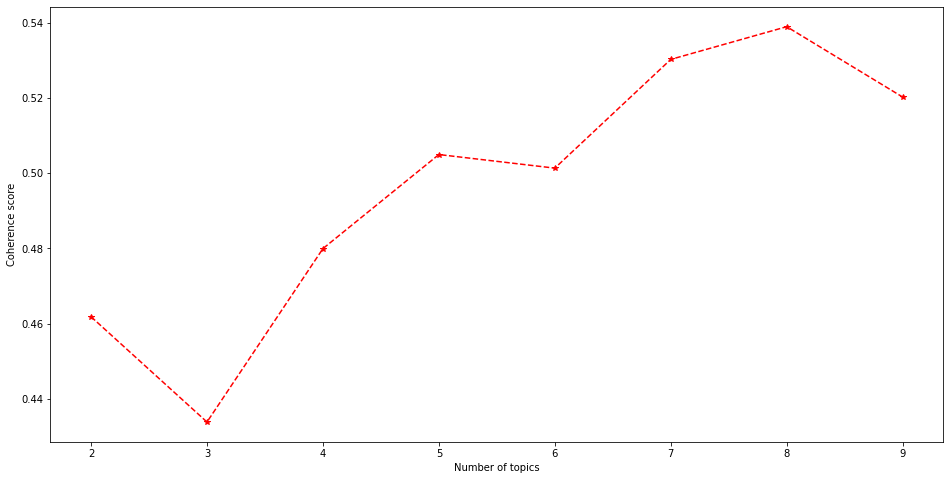

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.plot(topic_num,cv_score,color='RED', marker='*', linestyle='dashed')
plt.xticks(range(2,10))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [34]:
# Creating LDA model with number of topics as 2
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(corpus=corpus,id2word=id2word,num_topics=2,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
clear_output()

In [35]:
print(CoherenceModel(model=ldamodel2,texts=df['cleaned_text2'],dictionary=id2word , coherence='c_v').get_coherence())


0.4618587082655068


In [36]:
ldamodel2.print_topics()


[(0,
  '0.027*"discuss" + 0.020*"new" + 0.015*"military" + 0.014*"death" + 0.014*"kill" + 0.012*"cooperation" + 0.012*"head" + 0.012*"meet" + 0.011*"attack" + 0.011*"terrorist"'),
 (1,
  '0.050*"sisi" + 0.033*"egyptian" + 0.014*"say" + 0.008*"official" + 0.008*"sentence" + 0.008*"law" + 0.007*"year" + 0.007*"day" + 0.007*"minister" + 0.007*"development"')]

In [37]:
vis2 = gensim_models.prepare(ldamodel2, corpus, id2word, mds="mmds", R=30)
vis2

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.069577  0.219639       1        1  57.426662
0      0.069577 -0.219639       2        1  42.573338, topic_info=            Term         Freq        Total Category  logprob  loglift
6           sisi  1518.000000  1518.000000  Default  30.0000  30.0000
23       discuss   611.000000   611.000000  Default  29.0000  29.0000
5            new   448.000000   448.000000  Default  28.0000  28.0000
576     military   345.000000   345.000000  Default  27.0000  27.0000
530        death   315.000000   315.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
952  temperature   137.261323   138.513493   Topic2  -5.0993   0.8449
327      african   100.610862   101.329591   Topic2  -5.4099   0.8468
347       terror   129.468648   130.732324   Topic2  -5.1577   0.8442
449      country   113.188957   115.009094   Topic2  -5.2921   0.8380
17      egyptian   108.147991  1110.853182   Topic2  -5.3377  -1.4754

[103 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
327       1  0.009869  african
327       2  0.996747  african
324       1  0.986164    ahead
324       2  0.015779    ahead
0         1  0.997049  approve
...     ...       ...      ...
118       2  0.005440     will
1297      1  0.995998    woman
1297      2  0.008893    woman
93        1  0.999602     year
93        2  0.004384     year

[144 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [48]:
# Creating a lookup table for topics
topic_data = pd.DataFrame((ldamodel2.print_topics()),columns=['TopicNumber','TopKeywords'])
topic_data['TopicName'] = ['Political Negative Reviews Initiatives', 'Political Leaders in Egypt'] #enter selected topics names here
topic_data = topic_data[['TopicNumber','TopicName','TopKeywords']]
topic_data['TopKeywords'] = topic_data.TopKeywords.str.replace(r'[^a-z]',' ',regex=True).apply(lambda x: x.split())
topic_data.style.set_properties(subset=['TopKeywords'], **{'width': '300px'}) #space between columns

,TopicNumber,TopicName,TopKeywords
0,0,Political Negative Reviews Initiatives,"['discuss', 'new', 'military', 'death', 'kill', 'cooperation', 'head', 'meet', 'attack', 'terrorist']"
1,1,Political Leaders in Egypt,"['sisi', 'egyptian', 'say', 'official', 'sentence', 'law', 'year', 'day', 'minister', 'development']"


In [49]:
df.isnull().sum()


political_review    0
date                0
cleaned_text        0
cleaned_text1       0
cleaned_text2       0
LabelFromVADER      0
TopicNumber         0
TopicName           0
label               0
dtype: int64

In [50]:
#Creating new columns and inserting topic numbers and names
for y,sent in enumerate(ldamodel2[corpus]):
  topic_num =[]
  topic_details = sorted(sent,key=lambda x: x[1], reverse=True)[:2] # Getting top 2 topics in descending order
  topic_num.append(topic_details[0][0]) # Appending top topic
  if len(topic_details) > 1:
    if topic_details[1][1] > 0.35: # Appending second topic only if it has more than 35% influence on current row
      topic_num.append(topic_details[1][0])
  df.loc[y,'TopicNumber'] = ','.join(str(x) for x in sorted(topic_num))

In [51]:
df.dropna(inplace = True)

In [52]:
for index,topic_num in enumerate(df.TopicNumber):
  topic_name_list=[]
  for single_topic_num in (topic_num).split(','):
    single_topic_num=int(single_topic_num)
    topic_name_list.append(topic_data.loc[topic_data.TopicNumber == single_topic_num,'TopicName'][single_topic_num]) 
  # Extracting topic names from lookup table
  df.loc[index,'TopicName'] =' & '.join(topic_name_list)

In [63]:
df.head()


,political_review,date,cleaned_text,cleaned_text1,cleaned_text2,LabelFromVADER,TopicNumber,TopicName,label
0,Parliament approves law setting up Egyptian He...,2022-02-09,parliament approves law setting up egyptian he...,approve law set,"[approve, law, set]",neg,"0,1",Political Negative Reviews Initiatives & Polit...,Political Negative Reviews Initiatives & Polit...
1,New head of Egypt's Supreme Constitutional Cou...,2022-02-09,new head of egypt is supreme constitutional co...,new head constitutional court swear sisi,"[new, head, constitutional_court, swear, sisi]",neg,"0,1",Political Negative Reviews Initiatives & Polit...,Political Negative Reviews Initiatives & Polit...
2,Egypt’s HR council hails as 'historic step' th...,2022-02-09,egypt s hr council hails as historic step the ...,hail historic step appointment eskandar head c...,"[hail, historic, step, appointment, eskandar, ...",neg,"0,1",Political Negative Reviews Initiatives & Polit...,Political Negative Reviews Initiatives & Polit...
3,Sisi names first Christian as president of Egy...,2022-02-08,sisi names first christian as president of egy...,sisi name first constitutional court,"[sisi, name, first, constitutional_court]",neg,1,Political Leaders in Egypt,Political Leaders in Egypt_neg
4,Egyptian parliament rejects draft law imposing...,2022-02-08,egyptian parliament rejects draft law imposing...,egyptian reject draft law impose fine parent a...,"[egyptian, reject, draft, law, impose, fine, p...",neg,1,Political Leaders in Egypt,Political Leaders in Egypt_neg


In [64]:
df['label'] = df.TopicName.str.cat(df.LabelFromVADER, sep='_')


In [65]:
df.to_csv('LDA_Political_Reviews.csv')
